# The Book - Playing the Percentages in Baseball

I am reading through [The Book](http://www.insidethebook.com/) and I want to run some of the analyses that they discuss.

## Setup

In [1]:
import numpy as np
import pandas as pd
import pybaseball
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

import scipy.stats as stats
import statsmodels.api as sm

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 
 

# Chapter 1 - Toolshed

Lets start by gathering data to recreate some of the tables. In the book, the data used are from 1999-2002. Let's use Statcast era data starting in 2015. 

## Get data

In [2]:
# Either load data or gather using pybaseball
load_data = True # False #

In [3]:
# Dates for gathering data
start_date = '2015-04-01'
end_date   = '2022-11-01'

# Get data
if not load_data:
    # Get data using pybaseball
    data = pybaseball.statcast(start_dt=start_date,end_dt=end_date)
    first_total = len(data.index)
    print("Total number of pitches in raw data: ", first_total)
    
    # Sort by date and reset the index
    temp = data.sort_values(by="game_date")
    data = temp.reset_index()

    # Remove rows from exhibition and spring training
    data = data[~data['game_type'].isin(['E','S'])]

    # Dump file for faster access later
    data.to_pickle("data/statcast_data_2015-2022_raw.pkl")
else:    
    # Read raw data
    print("Loading data...",end="")
    data = pd.read_pickle("data/statcast_data_2015-2022_raw.pkl")
total_pitches_raw = len(data.index)
print("done.")


Loading data...done.


Do some conversions to improve performance

In [4]:
import datetime as dt
# Add game date as int column
data["game_date_int"] = data.game_date.dt.strftime("%Y%m%d").to_numpy(dtype="int")
# Add inning top/bottom as one-hot for speed
data["inning_topbot_onehot"] = pd.get_dummies(data.inning_topbot).loc[:,"Bot"].to_numpy()
# Sort data in order of date --> game --> inning --> at-bat # in game --> pitcher number in at-bat
data = data.sort_values(by=["game_date","game_pk","inning","at_bat_number","pitch_number"])

# Group data and add at-bat number in inning
grouped = data.groupby(["game_pk","inning","inning_topbot_onehot"])
data["at_bat_number_inning"] = grouped.at_bat_number.transform(lambda x: x - x.iloc[0])
data["outs_at_end_pa"] = grouped.outs_when_up.shift(periods=-1,fill_value=3)


## Run expectancy

In order to start calculating run expectancies, we need to group the data by game_date and inning. From there we can start counting different events. 

Let's start by estimating the run expectancy for each inning w/o attention to specific conditions. We will try it two ways: first, by looking at total runs and dividing by nine innings, and second, by looking at each inning independently. The linearity of averaging should reveal identical results, BUT ... baseball is weird...

In the book they exclude the home half of the 9th since it not played if the home team is ahead, or it ends when home team takes the lead. Therefore, in some cases, the home team does not play through all states of the inning. Perhaps the  data at the time did not allow for through enough filtering of the data, but here we can account for those things. Let's try first the checking the score at the end of the top of the ninth. 

In [5]:
# Just look at top of ninth score
group_by_date = data.loc[(data.inning == 9) & (data.inning_topbot_onehot == 0),:].groupby(by="game_pk")

homeA = []
awayA = []

from tqdm import tqdm

for (name,group) in tqdm(group_by_date):
    
    homeA.append(group.post_home_score.max()/8)
    awayA.append(group.post_away_score.max()/9)

print("Runs/8 innings (home team):  {:.2f}".format(np.mean(homeA)))
print("Runs/9 innings (away team):  {:.2f}".format(np.mean(awayA)))
print("Runs/9 innings (both teams): {:.2f}".format(np.mean(np.array(np.mean(homeA),np.mean(awayA))))) # <-- mean(mean) since # innings is different for each

100%|██████████| 17389/17389 [00:08<00:00, 1953.53it/s]

Runs/8 innings (home team):  0.53
Runs/9 innings (away team):  0.48
Runs/9 innings (both teams): 0.53


This is a little lower than the 0.555 listed in the book, but basically we can assume 0.5 runs / 9 innings. Let's see what happens if we compute the average of runs gained per inning on a per inning basis.

In [6]:
# We are still only considering top of 9 and earlier to match the book (for now)
mask1 = (data.inning == 9) & (data.inning_topbot_onehot == 0)
mask2 = data.inning < 9 

# # This grouping operations take a while
grouped = data.loc[np.logical_or(mask1,mask2),:].groupby(["game_pk","inning","inning_topbot_onehot"])

df = grouped.agg({"post_home_score": "max", "home_score": "min","post_away_score": "max", "away_score": "min"}).reset_index()

away = df.loc[df.inning_topbot_onehot==0,"post_away_score"] - df.loc[df.inning_topbot_onehot==0,"away_score"]
home = df.loc[df.inning_topbot_onehot==1,"post_home_score"] - df.loc[df.inning_topbot_onehot==1,"home_score"]

print("Runs / inning (home team):  {:.2f}".format(np.mean(home)))
print("Runs / inning (away team):  {:.2f}".format(np.mean(away)))
print("Runs / inning (both teams): {:.2f}".format(np.mean(np.array(np.mean(home),np.mean(away)))))

Runs / inning (home team):  0.53
Runs / inning (away team):  0.48
Runs / inning (both teams): 0.53


Awesome, we get the same results as before. The linearity of expectation! 

Want to see something interesting, but not directly related? If you instead run the code like the cell below, then it is 11x slower! This is because of the `.agg` function.

In [7]:
RUN_SLOW_VERSION = False

if RUN_SLOW_VERSION:
    # We are still only considering top of 9 and earlier to match the book (for now)
    mask1 = (data.inning == 9) & (data.inning_topbot == 1)
    mask2 = data.inning < 9 

    # This grouping operations take a while
    grouped = data.loc[np.logical_or(mask1,mask2),:].groupby(["game_pk","inning","inning_topbot_onehot"])

    home = []
    away = []

    for (name,group) in tqdm(grouped):
        # Compute difference between max post-AB score and min of pre-AB score
        if name[-1] == 1:
            home.append(group.post_home_score.max() - group.home_score.min())
        elif name[-1] == 0:
            away.append(group.post_away_score.max() - group.away_score.min())

    print("Runs / inning (home team):  {:.2f}".format(np.mean(home)))
    print("Runs / inning (away team):  {:.2f}".format(np.mean(away)))
    print("Runs / inning (both teams): {:.2f}".format(np.mean(np.array(np.mean(home),np.mean(away)))))
else:
    print("Good choice not to run it!")


Good choice not to run it!


Out of curiosity, let's see what happens if we include the 9th+ innings. For the sake of maintaining the same *context*, as they define it in the book, we will only include innings where the full top/bottom is played. 

In [8]:
# Group data but do not apply mask so we can consider late inning games
grouped = data.groupby(["game_pk","inning","inning_topbot_onehot"])

# First aggregate to get runs scored per inning but add number of max(outs_when_up) to make sure its 2 (that means we already went through 0, 1, and 2 outs ---> next is 3 and inning over)
df1 = grouped.agg({"game_date": "first", "post_home_score": "max", "home_score": "min","post_away_score": "max", "away_score": "min","outs_when_up": "max"}).reset_index()

df2 = df1.groupby(by=["game_pk","inning"]).filter(lambda x: x["outs_when_up"].sum() >= 4)

df2["runs_inning_away"] = df2["post_away_score"] - df2["away_score"]
df2["runs_inning_home"] = df2["post_home_score"] - df2["home_score"]


print("Runs / inning (home team):  {:.2f}".format(df2.loc[df2.inning_topbot_onehot==1,"runs_inning_home"].mean()))
print("Runs / inning (away team):  {:.2f}".format(df2.loc[df2.inning_topbot_onehot==0,"runs_inning_away"].mean()))
print("Runs / inning (both teams): {:.2f}".format(np.mean((df2.loc[df2.inning_topbot_onehot==1,"runs_inning_home"].mean() , df2.loc[df2.inning_topbot_onehot==0,"runs_inning_away"].mean()))))



Runs / inning (home team):  0.53
Runs / inning (away team):  0.50
Runs / inning (both teams): 0.52


Ok, so it is almost exactly the same if we include more innings.

Another interesting pandas thing again. Similar to before, if you were to run this in a loop it would instead take longer than 30 minutes!!

In [9]:
RUN_SLOW_VERSION = False

if RUN_SLOW_VERSION:
    ##### THIS CELL TAKES FOREVER TO RUN #####
    grouped = data.groupby(["game_pk","inning"])
    group_names = [g for g in grouped.groups.keys()]

    # Runs
    home   = []
    away   = []

    # Inning
    home_inning = []
    away_inning = []

    for name in tqdm(group_names):
        # Now group by top/bottom of inning - use one hot to speed things up instead of checking strings
        group_by_topbot = data.loc[(data.game_pk == temp[0]) & (data.inning==temp[1]),:]
        # Check to make sure the inning went to botom and bottom was completed by making sure the minimum
        # outs_when_up is 2 (max possible) - value of outs_when_up = {0, 1, 2} 
        if (not 1 in group_by_topbot.inning_topbot_onehot.tolist()):
            continue
        elif max(group_by_topbot.loc[group_by_topbot.inning_topbot_onehot==1,"outs_when_up"]) < 2:
            continue 
        else:
                # Compute difference between max post-AB score and min of pre-AB score
                # Home team
                tempdat = group_by_topbot.loc[group_by_topbot.inning_topbot_onehot==1,:]
                home.append(max(tempdat.post_home_score) - min(tempdat.home_score))
                home_inning.append(name[1])
                
                # Away team
                tempdat = group_by_topbot.loc[group_by_topbot.inning_topbot_onehot==0,:]
                away.append(max(tempdat.post_away_score) - min(tempdat.away_score))
                away_inning.append(name[1])
                

    print("Runs / inning (home team):  {:.2f}".format(np.mean(home)))
    print("Runs / inning (away team):  {:.2f}".format(np.mean(away)))
    print("Runs / inning (both teams): {:.2f}".format(np.mean(np.array(np.mean(home),np.mean(away)))))
else:
    print("Good choice not to run it!")

Good choice not to run it!


Let's see something that is not discussed yet, but is likely to appear later. Is there a difference if we consider the which inning the runs are scored in? Is there a higher or lower runs/inning baseline for earlier versus later innings?

<AxesSubplot:xlabel='Inning', ylabel='Runs'>

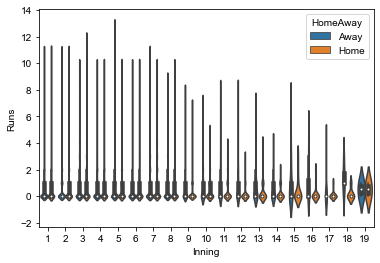

In [10]:
gg = df2.groupby(by="inning_topbot_onehot")
out = pd.DataFrame({"Runs": gg.get_group(0).runs_inning_away.to_list() + gg.get_group(1).runs_inning_home.to_list(), "Inning": gg.get_group(0).inning.to_list() + gg.get_group(1).inning.to_list(), "HomeAway": len(gg.get_group(0))*["Away"] + len(gg.get_group(1))*["Home"]})
sns.violinplot(data=out,x="Inning",y="Runs",hue="HomeAway")

This figure is pretty ugly and hard to evaluate, but I guess one interesting thing is that the error bars continue to decrease as the games get later into innings. That could be an interesting trend or simply related to the fact that there are likely many fewer games after nine innings than all of the rest.

In [11]:
pd.DataFrame(out.Inning.value_counts(normalize=True)).sort_index().rename(columns={"Inning": "% of all Innings in Data"})

,% of all Innings in Data
1,0.115311
2,0.116105
3,0.115808
4,0.115007
5,0.115882
6,0.115778
7,0.115089
8,0.114392
9,0.060888
10,0.007962


Yup, even the bottom of the 9th is only have as present in the data as the previous 8 innings. 

Alright, let's do one last thing before we start building the tables. What happens if the leadoff batter reaches first base?

In [12]:
# This is a less clean implementation in that we add a bunch of new columns, but I think these will be useful later so it is worth doing.
# It also signficantly decreases the time compared to using .agg or .filter, which I could not figure out how to do efficiently

# Group data before removing rows to add end of inning data
grouped = data.groupby(["game_pk","inning","inning_topbot_onehot"])

# Get runs at beginning of inning
data["begin_of_inning_runs_away"] = grouped.away_score.transform('min')
data["begin_of_inning_runs_home"] = grouped.home_score.transform('min')

# Get runs at end of inning
data["end_of_inning_runs_away"] = grouped.post_away_score.transform('max')
data["end_of_inning_runs_home"] = grouped.post_home_score.transform('max')#lambda x: x["post_away_score"].max() - x["away_score"].min())

# Get total runs scored in inning
data["runs_scored_in_inning_away"] = data["end_of_inning_runs_away"] - data["begin_of_inning_runs_away"]
data["runs_scored_in_inning_home"] = data["end_of_inning_runs_home"] - data["begin_of_inning_runs_home"]

# Get columns of data for home/away
home = data.loc[(data.at_bat_number_inning == 0) & (data.events.isin(["single"])) & (data.inning_topbot_onehot==1),"runs_scored_in_inning_home"]
away = data.loc[(data.at_bat_number_inning == 0) & (data.events.isin(["single"])) & (data.inning_topbot_onehot==0),"runs_scored_in_inning_away"]

print("Runs / inning (home team):  {:.2f}".format(np.mean(home)))
print("Runs / inning (away team):  {:.2f}".format(np.mean(away)))
print("Runs / inning (both teams): {:.2f}".format(np.mean(np.array(np.mean(home),np.mean(away)))))

Runs / inning (home team):  0.92
Runs / inning (away team):  0.86
Runs / inning (both teams): 0.92


Note: these are for cases when the lead-off batter gets on first w/no outs. In the book they make reference to lead-off batter as well as times when teams had a man on first w/no outs. Those are not always the same, such as a single later in the inning with outs on the books. This gets to the later tables, but let's just see what it looks like for any single w/no outs and no one on base. 

In [13]:
# Fill na values with 0
data[["on_1b","on_2b","on_3b"]] = data.loc[:,["on_1b","on_2b","on_3b"]].fillna(0)

# Get columns of data for home/away
mask = (data.on_1b==0) & (data.on_2b==0) & (data.on_3b==0) & (data.outs_when_up == 0) & (data.events.isin(["single"])) & (data.inning_topbot_onehot==1)
home = data.loc[mask,"runs_scored_in_inning_home"]
mask = (data.on_1b==0) & (data.on_2b==0) & (data.on_3b==0) & (data.outs_when_up == 0) & (data.events.isin(["single"])) & (data.inning_topbot_onehot==0)
away = data.loc[mask,"runs_scored_in_inning_away"]

print("Runs / inning (home team):  {:.2f}".format(np.mean(home)))
print("Runs / inning (away team):  {:.2f}".format(np.mean(away)))
print("Runs / inning (both teams): {:.2f}".format(np.mean(np.array(np.mean(home),np.mean(away)))))

Runs / inning (home team):  0.98
Runs / inning (away team):  0.93
Runs / inning (both teams): 0.98


### Table 1: Run Expectancy, By the 24 Base/Out States

In [14]:
# Add this since we don't need to separate home/away
data.loc[data.inning_topbot_onehot==0,"runs_scored_in_inning"] = data.loc[data.inning_topbot_onehot==0,"runs_scored_in_inning_away"]
data.loc[data.inning_topbot_onehot==1,"runs_scored_in_inning"] = data.loc[data.inning_topbot_onehot==1,"runs_scored_in_inning_home"]

In [15]:
# Add binary column to say if anyone is on each base instead of the player's name
data["on_1b_anyone"] = data["on_1b"]>0
data["on_2b_anyone"] = data["on_2b"]>0
data["on_3b_anyone"] = data["on_3b"]>0

# Create dataframe - this is not the prettiest operation but it will give us the data in the same presentation as the book
run_expectancy = pd.DataFrame({"1B": [], "2B": [], "3B": [], "0 Outs": [], "1 Out": [], "2 Outs": []})
# But actually for this one we will loop through men on base and then do outs for each one
from itertools import product 

for state in product((0,1),repeat=3):
    temp = []
    for outs in [0,1,2]:
        # Mask
        mask = (data.on_1b_anyone==state[0]) & (data.on_2b_anyone==state[1]) & (data.on_3b_anyone==state[2]) & (data.outs_when_up == outs) 
        # Add data to list for each out
        temp.append(np.mean(data.loc[mask,"runs_scored_in_inning"]))
    
    # pd.DataFrame({"1B", [])
    run_expectancy = pd.concat([run_expectancy,pd.DataFrame({"1B": ["1B" if state[0] else "-"], "2B": ["2B" if state[1] else "-"], "3B": ["3B" if state[2] else "-"], "0 Outs": [temp[0]], "1 Out": [temp[1]], "2 Outs": [temp[2]]})])
    
# Show data frame
run_expectancy.sort_values(by=["0 Outs","1 Out","2 Outs"])

,1B,2B,3B,0 Outs,1 Out,2 Outs
0,-,-,-,0.567005,0.442443,0.438614
0,1B,-,-,0.996246,0.763644,0.665893
0,-,2B,-,1.377601,1.126034,1.013266
0,1B,2B,-,1.736716,1.380426,1.092219
0,-,-,3B,1.804664,1.482772,1.093178
0,1B,-,3B,2.155624,1.805849,1.359286
0,-,2B,3B,2.446027,2.053677,1.442879
0,1B,2B,3B,2.775889,2.271438,1.626754


Awesome! These numbers are a bit higher but not outrageous. Makes sense if batter's are jacking more balls and scoring more runs. Not completely sure if this true but it is not something I will look into right now. 

## Run Values

Now lets look at the run value of the various events in the statcast data. I will replicate the table information but not exactly. Our calculation is on a per inning basis so I am not adding the runs to the end of the inning total. I will also not limit it to just those in the book. 

### Table 2: Runs to End of Inning by Event


In [16]:
average_runs, event_name, N = [], [], []
for name, group in data.groupby(by="events"):
    # Add data to list for each out
    average_runs.append(np.mean(group["runs_scored_in_inning"]))
    event_name.append(name)
    N.append(len(group["runs_scored_in_inning"]))

pd.DataFrame({"Event": event_name, "N": N, "Average Runs": average_runs}).sort_values(by=["Average Runs"],ascending=False).set_index("Event").dropna()

,N,Average Runs
Event,,
stolen_base_home,1,4.000000
stolen_base_3b,1,3.000000
home_run,41994,2.191170
sac_fly,8511,2.024556
fielders_choice,2728,1.998534
triple,5715,1.865442
sac_fly_double_play,126,1.674603
double,59427,1.568109
intent_walk,1923,1.379615


### Table 3: Runs to End Of Inning, By Event (Part 2)

Generate data first

In [17]:
# Generate base/out states
from itertools import product
base_out_state = [i+(j,) for j in [0,1,2] for i in product((0,1),repeat=3)]

# Add columns for starting run expectancy
data["starting_run_expectancy"] = 0

# Add values for each base/out state
starting_run_expectancy = []
for state in base_out_state:
    # Mask
    mask = (data.on_1b_anyone==state[0]) & (data.on_2b_anyone==state[1]) & (data.on_3b_anyone==state[2]) & (data.outs_when_up == state[3])
    # Add data to list for each out
    starting_run_expectancy.append(data.loc[mask,"runs_scored_in_inning"].mean())


for (state, re) in zip(base_out_state,starting_run_expectancy):
    mask = (data.on_1b_anyone==state[0]) & (data.on_2b_anyone==state[1]) & (data.on_3b_anyone==state[2]) & (data.outs_when_up == state[3])
    data.loc[mask, "starting_run_expectancy"] = re

Make table

In [18]:
average_runs, event_name, starting_re, N = [], [], [], []
for name, group in data.groupby(by="events"):
    # Get average runs to end of inning
    average_runs.append(group["runs_scored_in_inning"].mean())
    # Get average starting run expectancy for each event
    starting_re.append(group["starting_run_expectancy"].mean())
    # Save event name
    event_name.append(name)
    # Add number of each
    N.append(len(group))

pd.DataFrame({"Event": event_name, "N": N, "Average Runs": average_runs, "Starting RE": starting_re}).sort_values(by="Average Runs",ascending=False).set_index("Event").dropna()

,N,Average Runs,Starting RE
Event,,,
stolen_base_home,1,4.000000,1.359286
stolen_base_3b,1,3.000000,1.092219
home_run,41994,2.191170,0.763375
sac_fly,8511,2.024556,2.011986
fielders_choice,2728,1.998534,1.285392
triple,5715,1.865442,0.791228
sac_fly_double_play,126,1.674603,2.163822
double,59427,1.568109,0.780342
intent_walk,1923,1.379615,1.362349


### Table 4: Runs to End Of Inning, By Event (Part 3)

In [19]:
average_runs, event_name, starting_re, run_value, N = [], [], [], [], []
for name, group in data.groupby(by="events"):
    # Get average runs to end of inning
    average_runs.append(group["runs_scored_in_inning_home"].mean())
    # Get average starting run expectancy for each event
    starting_re.append(group["starting_run_expectancy"].mean())
    # Get average run value after
    run_value.append(np.mean(group["runs_scored_in_inning_home"] - group["starting_run_expectancy"]))
    # Save event name
    event_name.append(name)
    # Add number of each event
    N.append(len(group))

pd.DataFrame({"Event": event_name, "N": N, "Average Runs": average_runs, "Starting RE": starting_re, "Run Value": run_value}).sort_values(by="Run Value",ascending=False).set_index("Event").dropna()

,N,Average Runs,Starting RE,Run Value
Event,,,,
stolen_base_home,1,4.000000,1.359286,2.640714
stolen_base_3b,1,3.000000,1.092219,1.907781
home_run,41994,1.111849,0.763375,0.348474
triple,5715,1.015223,0.791228,0.223995
double,59427,0.795480,0.780342,0.015138
catcher_interf,252,0.813492,0.893308,-0.079815
field_error,9506,0.624132,0.749994,-0.125862
single,191907,0.636756,0.785808,-0.149051
walk,106015,0.580720,0.783944,-0.203224


## Run Values by State/Transition

### Table 5: Runs to End Of Inning, By Base/Out State, For HR

In [20]:
avg_reoi, start_re, run_val = [], [], []

# Create dataframe - this is not the prettiest operation but it will give us the data in the same presentation as the book
run_expectancy = pd.DataFrame({"1B": [], "2B": [], "3B": [], "Outs": [], "Avg REOI": [], "Start RE": [], "Run Value": []})

for state in base_out_state:
        # Get mask
        mask = (data.events == "home_run") & (data.on_1b_anyone==state[0]) & (data.on_2b_anyone==state[1]) & (data.on_3b_anyone==state[2]) & (data.outs_when_up == state[3])
        # Add to data frame
        run_expectancy = pd.concat([run_expectancy,
                                    pd.DataFrame({"1B":        ["1B" if state[0] else "-"], 
                                                  "2B":        ["2B" if state[1] else "-"], 
                                                  "3B":        ["3B" if state[2] else "-"], 
                                                  "Outs":      [state[3]], 
                                                  "Avg REOI":  [round(data.loc[mask,"runs_scored_in_inning"].mean(),3)], 
                                                  "Start RE":  [round(data.loc[mask,"starting_run_expectancy"].mean(),3)], 
                                                  "Run Value": [round(np.mean(data.loc[mask,"runs_scored_in_inning"] - data.loc[mask,"starting_run_expectancy"]),3)]})])
# Show data frame                                                  
run_expectancy.sort_values(by="Avg REOI")

,1B,2B,3B,Outs,Avg REOI,Start RE,Run Value
0,-,-,-,1.0,1.466,0.442,1.023
0,-,-,-,2.0,1.497,0.439,1.058
0,-,-,-,0.0,1.597,0.567,1.030
0,1B,-,-,2.0,2.588,0.666,1.923
0,1B,-,-,1.0,2.593,0.764,1.829
0,1B,-,-,0.0,2.650,0.996,1.654
0,-,2B,-,0.0,2.760,1.378,1.382
0,-,2B,-,1.0,2.769,1.126,1.643
0,-,-,3B,1.0,2.826,1.483,1.343
0,-,-,3B,2.0,2.888,1.093,1.795


### Table 6: Run Value of HR, By Base/Out State

In [21]:
# Add runs scored in plate appearance (pa)
data.loc[data.inning_topbot_onehot==0,"runs_scored_in_pa"] = data.loc[data.inning_topbot_onehot==0,"post_away_score"] - data.loc[data.inning_topbot_onehot==0,"away_score"]
data.loc[data.inning_topbot_onehot==1,"runs_scored_in_pa"] = data.loc[data.inning_topbot_onehot==1,"post_home_score"] - data.loc[data.inning_topbot_onehot==1,"home_score"]

In [22]:
# Group data before removing rows to add end of inning data
grouped = data.groupby(["game_pk","inning","inning_topbot_onehot"])
group_names = [g for g in grouped.groups.keys()]

# Add ending run expectancy by shifting each group by one (end value becomes nan since its end of inning)
data["ending_run_expectancy"] = grouped.starting_run_expectancy.shift(-1)
data["ending_run_expectancy"] = data["ending_run_expectancy"].astype("float") + data["runs_scored_in_pa"].astype("float")

In [23]:
# Create dataframe - this is not the prettiest operation but it will give us the data in the same presentation as the book
run_expectancy = pd.DataFrame({"1B": [], "2B": [], "3B": [], "Outs": [], "N": [], "Original": [], "Starting RE": [], "Ending RE": [], "Run Value": []})
temp = data.dropna(subset=["ending_run_expectancy"]).copy()
for state in base_out_state:
        # Get mask
        mask = (temp.events == "home_run") & (temp.on_1b_anyone==state[0]) & (temp.on_2b_anyone==state[1]) & (temp.on_3b_anyone==state[2]) & (temp.outs_when_up == state[3])
        # Add to data frame
        start_val = temp.loc[mask,"starting_run_expectancy"].astype("float").mean()
        end_val   = temp.loc[mask,"ending_run_expectancy"].astype("float").mean()
        run_expectancy = pd.concat([run_expectancy,
                                    pd.DataFrame({"1B":          ["1B" if state[0] else "-"], 
                                                  "2B":          ["2B" if state[1] else "-"], 
                                                  "3B":          ["3B" if state[2] else "-"], 
                                                  "Outs":        [state[3]], 
                                                  "N":           [len(temp.loc[mask,:])],
                                                  "Original":    [round(np.mean(temp.loc[mask,"runs_scored_in_inning"] - temp.loc[mask,"starting_run_expectancy"]),3)],
                                                  "Starting RE": [round(start_val,3)], 
                                                  "Ending RE":   [round(end_val,3)], 
                                                  "Run Value":   [round(end_val-start_val,3)]})])
# Show data frame                                                  
run_expectancy

,1B,2B,3B,Outs,N,Original,Starting RE,Ending RE,Run Value
0,-,-,-,0.0,11063.0,1.036,0.567,1.567,1.000
0,-,-,3B,0.0,92.0,1.098,1.805,2.567,0.762
0,-,2B,-,0.0,629.0,1.405,1.378,2.567,1.189
0,-,2B,3B,0.0,125.0,1.506,2.446,3.567,1.121
0,1B,-,-,0.0,2415.0,1.662,0.996,2.567,1.571
0,1B,-,3B,0.0,207.0,1.811,2.156,3.567,1.411
0,1B,2B,-,0.0,571.0,2.023,1.737,3.567,1.830
0,1B,2B,3B,0.0,149.0,2.123,2.776,4.567,1.791
0,-,-,-,1.0,7388.0,1.027,0.442,1.442,1.000
0,-,-,3B,1.0,318.0,1.351,1.483,2.442,0.960


In preparation for the next table, we can see how we calculate the weighted average for each base-out state

In [24]:
print("Average run value for the HR: {}".format(round(np.sum((run_expectancy["Run Value"] * run_expectancy["N"])) / run_expectancy["N"].sum(),3)))

Average run value for the HR: 1.292


### Table 7 - Run Values by Event

Something I noticed when making the table below is that the statcast data from Baseball Savant has a strange of labeleling events. For example, for the "wild pitch", it is always an inning/game ending play. In some cases, for example, there are runners in scoring position, they steal home on a 2-out wild pitch, and are tagged out at home. In other cases, they are in the bottom of extra innings and a wild pitch scores a walk-off run. It is strange because there is no way that every wild pitch ends in these two ways. 

In [25]:
# Using temp from above
run_value, event_name = [], []
tempdf = pd.DataFrame({"R":[], "N":[]})
temp = data.copy()#data.dropna(subset=["ending_run_expectancy"]).copy()
for name, group in temp.groupby(by="events"):
        temp_run_val, N = [], []
        for state in base_out_state:
                # Get mask
                mask = (group.on_1b_anyone==state[0]) & (group.on_2b_anyone==state[1]) & (group.on_3b_anyone==state[2]) & (group.outs_when_up == state[3])
                temp2 = group.loc[mask,["starting_run_expectancy","ending_run_expectancy"]].astype("float").dropna()
                N.append(len(temp2))
                if len(temp2) > 0: 
                        # Add to data frame
                        start_val = temp2.loc[mask,"starting_run_expectancy"].to_numpy("float")
                        end_val   = temp2.loc[mask,"ending_run_expectancy"].to_numpy("float")
                        temp_run_val.append(np.mean(end_val-start_val)) #end_val-start_val) #
                else:
                        temp_run_val.append(0)

        event_name.append(name)
        val = np.sum(np.multiply(temp_run_val,N)) / np.sum(N) if np.sum(N) > 0 else 0
        run_value.append(val)

# tempdf
run_value_df = pd.DataFrame({"Event": event_name, "Run Value": run_value})
run_value_df.sort_values(by="Run Value",ascending=False).set_index('Event',drop=True)

,Run Value
Event,
triple,1.294594
home_run,1.291621
double,0.964074
fielders_choice,0.823187
field_error,0.537448
single,0.529415
catcher_interf,0.475314
hit_by_pitch,0.427787
walk,0.401302


The reason that some of the values in the above table are zero is because in some cases (like the weird wild pitch thing noted before the last code cell), there are no plays for that event and base/out state combo that result in a change. When I compute ending run expectancy, I group by the game, inning, and top/bot of the inning and then add a new column with the starting run expectancy of the next play shifted back one to reflect the ending run expectancy of that play. In this case, the last play of the inning will be a nan ending run expectancy. For some cases, we never see an event happen for any of the base/out states, thus we do not have any values to report. That was giving errors in the weighted average calculation, so I just set it to zero if there are no events. In reality, this is probably not true since an inning-ending play surely reduces the run expectancy more than just an out since no more runs can be scored. For now this is the best we can do. 

One last thing we can check is to see if our calculation is similiar to the one already in the statcast data. 

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_23198/3528728267.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  temp = data.loc[:,["change_run_expectancy","delta_run_exp"]].astype("float").dropna(0).copy()


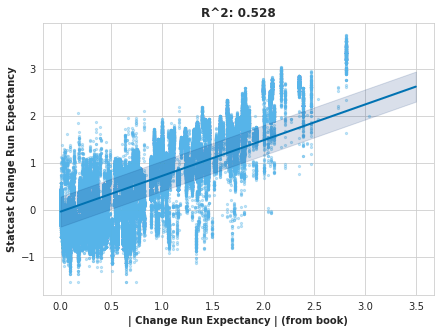

In [26]:
# OLS using statsmodels
def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result


# Calculate change in run expectancy 
data["change_run_expectancy"] = np.absolute(data["starting_run_expectancy"] - data["ending_run_expectancy"])

# Get data and drop nans
temp = data.loc[:,["change_run_expectancy","delta_run_exp"]].astype("float").dropna(0).copy()

with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    
    # Plot raw data
    ax.scatter(temp["change_run_expectancy"],temp["delta_run_exp"],color=skyblue,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["change_run_expectancy"].to_numpy("float"),temp["delta_run_exp"].to_numpy("float"))
    xvals= np.linspace(0,3.5,1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax.fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=skyblue,alpha=0.15,label="Confidence Intervals")
    ax.fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax.plot(xvals,model.predict(xvals2),color=blue_cb,lw=2,label="OLS result")
    ax.set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax.set_xlabel("| Change Run Expectancy | (from book)",fontweight="bold")
    ax.set_ylabel('Statcast Change Run Expectancy',fontweight="bold")


It could be that these values are computed on a per season basis or maybe they use the prior season data for the current season. Or, they are likely considering the count as part of the run expectancy, which is likely why just about every play results in a change despite the outs/bases not always changing. 

## Weighted On Base Average - wOBA

Now that we have our run values calculated, we can proceed to calculate wOBA for each player. Again we can use the pybaseball to grab the data we need for this, which includes singles, doubles, HRs, etc.

In [27]:
# Plays that result in an out
out_plays = ['field_out', 'strikeout', 'force_out', 'grounded_into_double_play','sac_fly', 
             'sac_bunt', 'double_play', 'fielders_choice_out','strikeout_double_play',
             'sac_fly_double_play', 'triple_play','sac_bunt_double_play']

run_value_out = run_value_df.loc[run_value_df.Event.isin(out_plays),"Run Value"].mean()

# ["single","double","triple","home_run","walk","intent_walk", "hit_by_pitch","sac_fly","strikeout","field_out","field_error","grounded_into_double_play","force_out"]
# run_value_df["Run Value"].apply(lambda x: x-run_value_out)
run_value_df["Run Value Above Out"] = run_value_df["Run Value"] - run_value_out
run_value_df.sort_values(by="Run Value Above Out",ascending=False).set_index('Event',drop=True)

,Run Value,Run Value Above Out
Event,,
triple,1.294594,1.650556
home_run,1.291621,1.647583
double,0.964074,1.320035
fielders_choice,0.823187,1.179149
field_error,0.537448,0.893409
single,0.529415,0.885377
catcher_interf,0.475314,0.831276
hit_by_pitch,0.427787,0.783748
walk,0.401302,0.757264


In [28]:
from pybaseball import fg_batting_data
# Change qual --> 0 if we want everyone that had a plate appearance
fg = fg_batting_data(start_season=2015,end_season=2022,split_seasons=True,qual=50,max_results=1_000_000_000)
# Alternatively, we can get the data directly from fangraphs, save as csv, and then load directly: 
# "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=50&type=8&season=2022&month=0&season1=2015&ind=1&team=0&rost=0&age=0&filter=&players=0&startdate=2015-01-01&enddate=2022-12-31&sort=5,a"

In [29]:
# Calculate wOBA for each row. 
def calculate_woba_no_scaling(row,runvals):
    weights = runvals.loc[runvals.Event.isin(["intent_walk","hit_by_pitch","single","double","triple","home_run"]),"Run Value Above Out"].to_numpy("float")
    batter_data = row[["IBB","HBP","1B","2B","3B","HR"]].to_numpy("float")
    row["my_wOBA_noScaling"] = np.sum(np.multiply(weights,batter_data))/row["PA"]
    return row

fg = fg.apply(lambda row: calculate_woba_no_scaling(row,run_value_df),axis=1)
fg

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,my_wOBA_noScaling
8,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,110.6,217,0.500,434,0.220,0.270,NaN,NaN,NaN,0.420648
10,10155,2018,Mike Trout,LAA,26,140,471,608,147,80,...,118.0,162,0.460,352,0.201,0.261,NaN,NaN,NaN,0.417521
4,11579,2015,Bryce Harper,WSN,22,153,521,654,172,91,...,116.0,188,0.477,394,0.118,0.226,NaN,NaN,NaN,0.405057
43,10155,2015,Mike Trout,LAA,23,159,575,682,172,93,...,117.7,205,0.486,422,0.207,0.282,NaN,NaN,NaN,0.396267
7,15640,2022,Aaron Judge,NYY,30,131,484,577,146,70,...,118.4,210,0.609,345,0.176,0.292,NaN,NaN,NaN,0.407429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,2579,2015,Carlos Ruiz,PHI,36,86,284,320,60,44,...,104.3,43,0.176,245,0.217,0.265,NaN,NaN,NaN,0.280176
3555,11165,2016,Ramon Flores,MIL,24,104,249,289,51,41,...,107.9,40,0.202,198,0.189,0.252,NaN,NaN,NaN,0.279623
2778,393,2015,Victor Martinez,DET,36,120,440,485,108,77,...,108.9,131,0.332,395,0.163,0.223,NaN,NaN,NaN,0.354938
3993,3448,2019,Jeff Mathis,TEX,36,88,228,244,36,25,...,105.5,37,0.261,142,0.155,0.322,NaN,NaN,NaN,0.208181


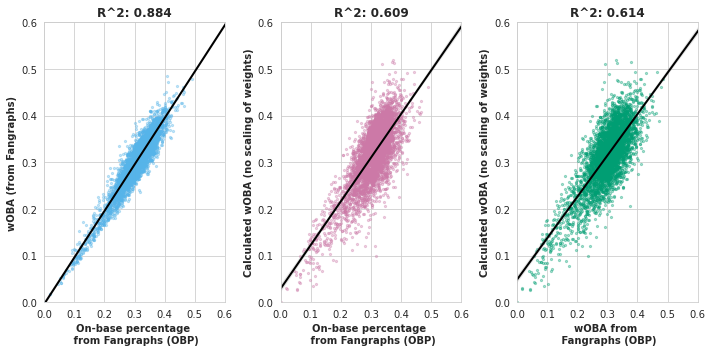

In [30]:
# Get data and drop nans
temp = fg.loc[:,["OBP","wOBA","my_wOBA_noScaling"]].astype("float")#.dropna(0).copy()

with sns.axes_style("whitegrid"):
    
     # Make figure
    fig, ax = plt.subplots(1,3)#,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)

    # First see OBP vs wOBA
    ax[0].scatter(temp["OBP"],temp["wOBA"],color=skyblue,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["OBP"],temp["wOBA"])
    xvals= np.linspace(0,1,1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[0].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[0].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[0].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[0].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[0].set_xlabel("On-base percentage \n from Fangraphs (OBP)",fontweight="bold")
    ax[0].set_ylabel('wOBA (from Fangraphs)',fontweight="bold")
    ax[0].set_xlim(0,.6)
    ax[0].set_ylim(0,.6)
    
    # Second see OBP vs my wOBA calculation where I don't scale the values
    ax[1].scatter(temp["OBP"],temp["my_wOBA_noScaling"],color=pink,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["OBP"],temp["my_wOBA_noScaling"])

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[1].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[1].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[1].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[1].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[1].set_xlabel("On-base percentage \n from Fangraphs (OBP)",fontweight="bold")
    ax[1].set_ylabel('Calculated wOBA (no scaling of weights)',fontweight="bold")
    ax[1].set_xlim(0,.6)
    ax[1].set_ylim(0,.6)

    # Third see fangraph's wOBA vs my wOBA calculation where I don't scale the values
    ax[2].scatter(temp["wOBA"],temp["my_wOBA_noScaling"],color=green,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["wOBA"],temp["my_wOBA_noScaling"])

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[2].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[1].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[2].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[2].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[2].set_xlabel("wOBA from \n Fangraphs (OBP)",fontweight="bold")
    ax[2].set_ylabel('Calculated wOBA (no scaling of weights)',fontweight="bold")
    ax[2].set_xlim(0,.6)
    ax[2].set_ylim(0,.6)

plt.tight_layout()

Add scaling to my wOBA calculation.

In [31]:
# Calculate wOBA for each row. 
def calculate_woba_with_scaling(row,runvals,scale):
    weights = runvals.loc[runvals.Event.isin(["intent_walk","hit_by_pitch","single","double","triple","home_run"]),"Run Value Above Out"].to_numpy("float")
    batter_data = row[["IBB","HBP","1B","2B","3B","HR"]].to_numpy("float")
    row["my_wOBA_withScaling"] = np.sum(np.multiply(weights + weights*scale,batter_data))/row["PA"]
    return row

scale = 1 - fg["OBP"].mean()/fg["my_wOBA_noScaling"].mean()

fg = fg.apply(lambda row: calculate_woba_with_scaling(row,run_value_df,scale),axis=1)
fg

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,my_wOBA_noScaling,my_wOBA_withScaling
8,13611,2018,Mookie Betts,BOS,25,136,520,614,180,96,...,217,0.500,434,0.220,0.270,NaN,NaN,NaN,0.420648,0.433445
10,10155,2018,Mike Trout,LAA,26,140,471,608,147,80,...,162,0.460,352,0.201,0.261,NaN,NaN,NaN,0.417521,0.430222
4,11579,2015,Bryce Harper,WSN,22,153,521,654,172,91,...,188,0.477,394,0.118,0.226,NaN,NaN,NaN,0.405057,0.417380
43,10155,2015,Mike Trout,LAA,23,159,575,682,172,93,...,205,0.486,422,0.207,0.282,NaN,NaN,NaN,0.396267,0.408322
7,15640,2022,Aaron Judge,NYY,30,131,484,577,146,70,...,210,0.609,345,0.176,0.292,NaN,NaN,NaN,0.407429,0.419824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,2579,2015,Carlos Ruiz,PHI,36,86,284,320,60,44,...,43,0.176,245,0.217,0.265,NaN,NaN,NaN,0.280176,0.288699
3555,11165,2016,Ramon Flores,MIL,24,104,249,289,51,41,...,40,0.202,198,0.189,0.252,NaN,NaN,NaN,0.279623,0.288130
2778,393,2015,Victor Martinez,DET,36,120,440,485,108,77,...,131,0.332,395,0.163,0.223,NaN,NaN,NaN,0.354938,0.365736
3993,3448,2019,Jeff Mathis,TEX,36,88,228,244,36,25,...,37,0.261,142,0.155,0.322,NaN,NaN,NaN,0.208181,0.214514


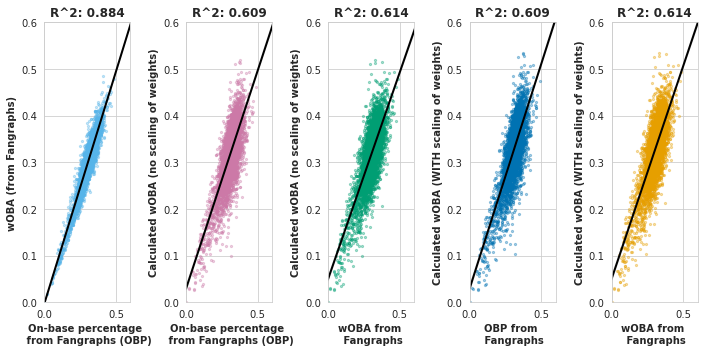

In [32]:
# Get data and drop nans
temp = fg.loc[:,["OBP","wOBA","my_wOBA_noScaling","my_wOBA_withScaling"]].astype("float")#.dropna(0).copy()

with sns.axes_style("whitegrid"):
    
     # Make figure
    fig, ax = plt.subplots(1,5)#,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)

    # First see OBP vs wOBA
    ax[0].scatter(temp["OBP"],temp["wOBA"],color=skyblue,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["OBP"],temp["wOBA"])
    xvals= np.linspace(0,1,1000)
    xvals2 = sm.add_constant(xvals)

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[0].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[0].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[0].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[0].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[0].set_xlabel("On-base percentage \n from Fangraphs (OBP)",fontweight="bold")
    ax[0].set_ylabel('wOBA (from Fangraphs)',fontweight="bold")
    ax[0].set_xlim(0,.6)
    ax[0].set_ylim(0,.6)
    
    # Second see OBP vs my wOBA calculation where I don't scale the values
    ax[1].scatter(temp["OBP"],temp["my_wOBA_noScaling"],color=pink,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["OBP"],temp["my_wOBA_noScaling"])

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[1].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[1].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[1].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[1].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[1].set_xlabel("On-base percentage \n from Fangraphs (OBP)",fontweight="bold")
    ax[1].set_ylabel('Calculated wOBA (no scaling of weights)',fontweight="bold")
    ax[1].set_xlim(0,.6)
    ax[1].set_ylim(0,.6)

    # Third see fangraph's wOBA vs my wOBA calculation where I don't scale the values
    ax[2].scatter(temp["wOBA"],temp["my_wOBA_noScaling"],color=green,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["wOBA"],temp["my_wOBA_noScaling"])

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[2].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[1].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[2].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[2].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[2].set_xlabel("wOBA from \n Fangraphs",fontweight="bold")
    ax[2].set_ylabel('Calculated wOBA (no scaling of weights)',fontweight="bold")
    ax[2].set_xlim(0,.6)
    ax[2].set_ylim(0,.6)


    # Third see fangraph's wOBA vs my wOBA calculation where I don't scale the values
    ax[3].scatter(temp["OBP"],temp["my_wOBA_withScaling"],color=blue_cb,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["OBP"],temp["my_wOBA_withScaling"])

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[3].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[1].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[3].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[3].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[3].set_xlabel("OBP from \n Fangraphs",fontweight="bold")
    ax[3].set_ylabel('Calculated wOBA (WITH scaling of weights)',fontweight="bold")
    ax[3].set_xlim(0,.6)
    ax[3].set_ylim(0,.6)

    # Third see fangraph's wOBA vs my wOBA calculation where I don't scale the values
    ax[4].scatter(temp["wOBA"],temp["my_wOBA_withScaling"],color=orange,alpha=.35,s=5)

    # Run regression
    model = run_regression(temp["wOBA"],temp["my_wOBA_withScaling"])

    # Plot Confidence and Prediction intervals
    CI = model.get_prediction(xvals2).summary_frame(alpha=0.05)
    ax[4].fill_between(xvals,CI.mean_ci_lower.to_numpy("float"),CI.mean_ci_upper.to_numpy("float"),color=grey,alpha=0.15,label="Confidence Intervals")
    # ax[1].fill_between(xvals,CI.obs_ci_lower.to_numpy("float"),CI.obs_ci_upper.to_numpy("float"),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[4].plot(xvals,model.predict(xvals2),color='k',lw=2,label="OLS result")
    ax[4].set_title("R^2: {}".format(round(model.rsquared,3)),fontweight="bold")
    ax[4].set_xlabel("wOBA from \n Fangraphs",fontweight="bold")
    ax[4].set_ylabel('Calculated wOBA (WITH scaling of weights)',fontweight="bold")
    ax[4].set_xlim(0,.6)
    ax[4].set_ylim(0,.6)

plt.tight_layout()

Clearly we are not accurately capturing the relationship between the values even after scaling (although its super small), but we are also neglecting quite a few things. For example, we are not doing this on a season-by-season basis. This is not difficult but out of the scope of what I want to do here. 